<a href="https://colab.research.google.com/github/marags-web/marags-web/blob/main/network_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network intrusion detection and classification

### 1. Import dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from google.colab import drive

In [ ]:
#drive.mount('/content/drive/') 
#path = '/content/drive/My Drive/Colab Notebooks/datasets/network_data_train.txt'
url =  "https://raw.githubusercontent.com/marags-web/marags-web/main/IDS/data/network_data_train.txt"


### 2. Data Preprocessing

In [ ]:
# data does not have column headers, so define them
headers = ["duration","protocol_type","service","flag","src_bytes",
           "dst_bytes","land","wrong_fragment","urgent","hot",
           "num_failed_logins","logged_in","num_compromised","root_shell",
           "su_attempted","num_root","num_file_creations","num_shells",
           "num_access_files","num_outbound_cmds","is_host_login",
           "is_guest_login","count","srv_count","serror_rate", 
           "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate", 
           "diff_srv_rate", "srv_diff_host_rate","dst_host_count",
           "dst_host_srv_count","dst_host_same_srv_rate",
           "dst_host_diff_srv_rate","dst_host_same_src_port_rate",
           "dst_host_srv_diff_host_rate","dst_host_serror_rate",
           "dst_host_srv_serror_rate","dst_host_rerror_rate",
           "dst_host_srv_rerror_rate","attack", "last_flag"]

# read csv
data = pd.read_csv(url, names=headers)

# choose relevent features
features = ['duration','src_bytes','dst_bytes','num_file_creations', 
           'num_shells','num_failed_logins','wrong_fragment', 
           'urgent', 'is_guest_login', 'su_attempted', 'land', 'attack']
df = data[features]

In [ ]:
pd.set_option('display.max_columns', None)
print(df.head())

   duration  src_bytes  dst_bytes  num_file_creations  num_shells  \
0         0        491          0                   0           0   
1         0        146          0                   0           0   
2         0          0          0                   0           0   
3         0        232       8153                   0           0   
4         0        199        420                   0           0   

   num_failed_logins  wrong_fragment  urgent  is_guest_login  su_attempted  \
0                  0               0       0               0             0   
1                  0               0       0               0             0   
2                  0               0       0               0             0   
3                  0               0       0               0             0   
4                  0               0       0               0             0   

   land   attack  
0     0   normal  
1     0   normal  
2     0  neptune  
3     0   normal  
4     0   normal  


In [ ]:
class_labels = ['normal', 'dos', 'probing', 'u2r', 'r2l']

# data has too many classes
# to simplify problem, categorize them generic network attack types : Probing, U2R, R2L, and DOS

dos = ['neptune', 'apache2', 'processtable', 'smurf', 'back', 'snmpguess', 'mailbomb', 'snmpgetattack',
              'pod', 'multihop', 'teardrop', 'sqlattack', 'land']
probing = ['mscan', 'satan', 'saint', 'portsweep', 'ipsweep', 'nmap', 'spy']
u2r = ['buffer_overflow', 'ps', 'xterm', 'perl', 'loadmodule', 'imap']
r2l = ['guess_passwd', 'warezmaster', 'httptunnel', 'named', 'sendmail', 'xlock','xsnoop', 'rootkit', 
       'ftp_write', 'worm', 'phf', 'udpstorm', 'warezclient']

# replace all values in dataframe with corresponding int value

df['attack'].replace('normal', 0, inplace=True)
df['attack'].replace(dos, 1, inplace=True)
df['attack'].replace(probing, 2, inplace=True)
df['attack'].replace(u2r, 3, inplace=True)
df['attack'].replace(r2l, 4, inplace=True)

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
df['attack'].value_counts()

0    67343
1    45934
2    11658
4      985
3       53
Name: attack, dtype: int64

In [ ]:
# split data into inputs/outputs
features = df[['duration','src_bytes','dst_bytes','num_file_creations', 
           'num_shells','num_failed_logins','wrong_fragment', 
           'urgent', 'is_guest_login', 'su_attempted', 'land']]
labels = df['attack']

X = np.array(features)
y = np.array(labels).reshape(-1, 1)

# make sure both arrays have correct dimensions
print(X.shape)
print(y.shape)

(125973, 11)
(125973, 1)


In [ ]:
np.unique(y)

array([0, 1, 2, 3, 4])

### 3. Buidling the model

In [ ]:
import timeit

start = timeit.default_timer()

model = Sequential()

model.add(Dense(units=32, activation='relu', input_dim=(11)))

model.add(Dense(units=24, activation='relu'))
model.add(Dropout(.2))

model.add(Dense(units=11, activation='relu'))
model.add(Dropout(.2))

model.add(Dense(units=8, activation='relu'))

model.add(Dense(units=5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'],run_eagerly=True)



In [ ]:
model.fit(X, y, epochs=10, batch_size=32)
stop = timeit.default_timer()
print('Time: ', stop - start)  

Epoch 1/10
3937/3937 [==============================] - 95s 24ms/step - loss: 226.9552 - accuracy: 0.7334
Epoch 2/10
3937/3937 [==============================] - 112s 28ms/step - loss: 115.9716 - accuracy: 0.7758
Epoch 3/10
3937/3937 [==============================] - 92s 23ms/step - loss: 21.4605 - accuracy: 0.7953
Epoch 4/10
3937/3937 [==============================] - 81s 21ms/step - loss: 9.2197 - accuracy: 0.8285
Epoch 5/10
3937/3937 [==============================] - 83s 21ms/step - loss: 55.2502 - accuracy: 0.8473
Epoch 6/10
3937/3937 [==============================] - 80s 20ms/step - loss: 1.3104 - accuracy: 0.8571
Epoch 7/10
3937/3937 [==============================] - 76s 19ms/step - loss: 0.5119 - accuracy: 0.8697
Epoch 8/10
3937/3937 [==============================] - 88s 22ms/step - loss: 0.4162 - accuracy: 0.8762
Epoch 9/10
3937/3937 [==============================] - 93s 24ms/step - loss: 0.4446 - accuracy: 0.8771
Epoch 10/10
3937/3937 [==============================] - 

In [ ]:
test_path = 'url =  "https://raw.githubusercontent.com/marags-web/marags-web/main/IDS/data/network_data_test.txt'

test = pd.read_csv(url, names=headers)

features = ['duration','src_bytes','dst_bytes','num_file_creations', 
           'num_shells','num_failed_logins','wrong_fragment', 
           'urgent', 'is_guest_login', 'su_attempted', 'land', 'attack']

test = test[features]

test['attack'].replace('normal', 0, inplace=True)
test['attack'].replace('dos', 1, inplace=True)
test['attack'].replace('probing', 2, inplace=True)
test['attack'].replace('u2r', 3, inplace=True)
test['attack'].replace('r2l', 4, inplace=True)

X_test, y_test = df.drop('attack', axis=1), df['attack']

val_loss, val_acc = model.evaluate(X_test, y_test) 



3937/3937 [==============================] - 44s 11ms/step - loss: 0.3954 - accuracy: 0.8865


In [ ]:
print(val_acc)
print(val_loss)

0.8865153789520264
0.3953530192375183


#### 88% Accuracy on validation data

In [ ]:
# generate a random index to make a prediction on
import random
import numpy 
import time 
import timeit
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

FONT_SIZE = 12
start = timeit.default_timer()
prediction_index = random.randint(0, len(X_test))

pred_input = np.array(list(X_test.iloc[prediction_index])).reshape(1, 11)
prediction = class_labels[model.predict(pred_input).argmax()]
actual = class_labels[y_test.iloc[prediction_index]]
   
stop = timeit.default_timer()
print('Time: ', stop - start)  

# compare prediction vs actual value
print(f'Predicted Value: {prediction}')
print(f'Actual Value: {actual}')

1/1 [==============================] - 0s 35ms/step
Time:  0.10627293599998211
Predicted Value: normal
Actual Value: normal


In [ ]:
predictions = model.predict(X_test)
predictions_labels = []
for row in predictions:
  predictions_labels.append(class_labels[row.argmax()])

actual_labels = []
for row in y_test:
  actual_labels.append(class_labels[row])

3937/3937 [==============================] - 17s 4ms/step


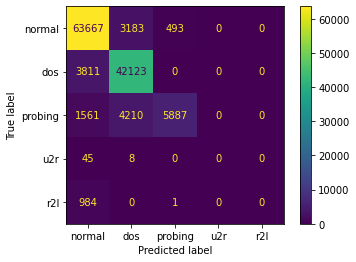

In [ ]:
cm = confusion_matrix(actual_labels, predictions_labels, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()

In [ ]:
from sklearn import metrics

Accuracy = metrics.accuracy_score(actual_labels, predictions_labels)
print("Accuracy",Accuracy)

print("Numerical values for normal packets")
# TP for all classes
TP = cm[0,0]
print("True Positive",cm[0,0])

# FN for 'normal' 
FN = cm[0,1] + cm[0,2] 
print("False Negative" ,FN)

# FP for 'normal' 
FP = cm[1,0] + cm[1,2] 
print ("False Positive", FP)

# TN for 'normal'
TN = cm[1,1] + cm[1,2] + cm[2,1] +cm [2,2]
print("True Negative" ,TN)


#Precision = TruePositives / (TruePositives + FalsePositives)
Precision = TP/(TP+FP)
print("Precision" ,Precision)

#Recall = TruePositives / (TruePositives + FalseNegatives)
Recall =TP/(TP+FN)
print ("Recall"  , Recall)

#F1_score = metrics.f1_score(actual_labels, predictions_labels)
F1_score = (2 * Precision * Recall) / (Precision + Recall)
print ("F1_score" ,F1_score)

Accuracy 0.8865153644034833
Numerical values for normal packets
True Positive 63667
False Negative 3676
False Positive 3811
True Negative 52220
Precision 0.9435223332048964
Recall 0.9454137772300016
F1_score 0.9444671082398143


In [ ]:
print("Numerical values for DoS packets")

TP = cm[1,1]
print("True Positive", TP)

# FN 
FN = cm[1,0] + cm[1,2] 
print("False Negative" ,FN)

# FP 
FP = cm[0,1] + cm[2,1] 
print ("False Positive", FP)

# TN 
TN = cm[0,0] + cm[0,2] + cm[2,0] +cm [2,2]
print("True Negative" ,TN)


#Precision = TruePositives / (TruePositives + FalsePositives)
Precision = TP/(TP+FP)
print("Precision" ,Precision)

#Recall = TruePositives / (TruePositives + FalseNegatives)
Recall =TP/(TP+FN)
print ("Recall"  , Recall)

#F1_score = metrics.f1_score(actual_labels, predictions_labels)
F1_score = (2 * Precision * Recall) / (Precision + Recall)
print ("F1_score" ,F1_score)

Numerical values for DoS packets
True Positive 42123
False Negative 3811
False Positive 7393
True Negative 71608
Precision 0.850694724937394
Recall 0.9170331344973223
F1_score 0.8826191723415401


In [ ]:
print("Numerical values for Probing packets")

TP = cm[2,2]
print("True Positive", TP)

# FN 
FN = cm[2,1] + cm[2,2] 
print("False Negative" ,FN)

# FP 
FP = cm[0,2] + cm[1,2] 
print ("False Positive", FP)

# TN 
TN = cm[0,0] + cm[0,1] + cm[1,0] +cm [1,1]
print("True Negative" ,TN)


#Precision = TruePositives / (TruePositives + FalsePositives)
Precision = TP/(TP+FP)
print("Precision" ,Precision)

#Recall = TruePositives / (TruePositives + FalseNegatives)
Recall =TP/(TP+FN)
print ("Recall"  , Recall)

#F1_score = metrics.f1_score(actual_labels, predictions_labels)
F1_score = (2 * Precision * Recall) / (Precision + Recall)
print ("F1_score" ,F1_score)

Numerical values for Probing packets
True Positive 5887
False Negative 10097
False Positive 493
True Negative 112784
Precision 0.9227272727272727
Recall 0.3683058058058058
F1_score 0.5264711142908245
